# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Данные находятся в файле /datasets/autos.csv. 
Признаки
 - DateCrawled — дата скачивания анкеты из базы
 - VehicleType — тип автомобильного кузова
 - RegistrationYear — год регистрации автомобиля
 - Gearbox — тип коробки передач
 - Power — мощность (л. с.)
 - Model — модель автомобиля
 - Kilometer — пробег (км)
 - RegistrationMonth — месяц регистрации автомобиля
 - FuelType — тип топлива
 - Brand — марка автомобиля
 - Repaired — была машина в ремонте или нет
 - DateCreated — дата создания анкеты
 - NumberOfPictures — количество фотографий автомобиля
 - PostalCode — почтовый индекс владельца анкеты (пользователя)
 - LastSeen — дата последней активности пользователя

Целевой признак
 - Price — цена (евро)

In [1]:
# Загрузим нужные библиотеки
try:
    import phik
except ModuleNotFoundError:
    ! pip install phik -q
    import phik

In [2]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 1.4.2.


In [15]:
# стандартные библиотеки
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import warnings
import time
from scipy import stats as st

# загружаем нужные модели Регрессии
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostClassifier

import lightgbm as lgb

# загружаем классы для подготовки данных
from sklearn.preprocessing import (
    OneHotEncoder, 
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler, 
    RobustScaler,
    LabelEncoder)

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# импортируем классы для перебора параметров 
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# загружаем функцию для работы с метриками
from sklearn.metrics import roc_auc_score, confusion_matrix, make_scorer

# загружаем класс pipeline
from sklearn.pipeline import Pipeline


# загружаем инструменты для анализа DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.tree import export_text
from shap import TreeExplainer

# загрузим дамми-модели
from sklearn.dummy import DummyRegressor
from sklearn.dummy import DummyClassifier

In [11]:
def df_uni_describe(df):
    """
    Universal function for describing a pandas DataFrame.

    Parameters:
    - df (pandas DataFrame): The DataFrame to be described.

    This function provides a comprehensive description of the DataFrame including:
    - Main info: Number of variables, number of observations, total missing values, and total duplicates.
    - Missing (NaNs) percentage per column if any.
    - Info of the DataFrame including data types and memory usage.
    - Head of the DataFrame.
    - Descriptive statistics for numerical columns.
    """
    try:
        # Main info
        print("\033[1m" + 'Main info:' + "\033[0m")
        print("Number of variables:", df.shape[1])
        print("Number of observations:", df.shape[0])
        total_missing = df.isna().sum().sum() / (df.shape[1] * df.shape[0])
        print('Total missing: {:.2%}'.format(total_missing))
        print('Total duplicates:', df.duplicated().sum())

        # Missing values
        if total_missing > 0:
            print("\033[1m" + 'Missing (NaNs), %' + "\033[0m")
            missing_percentage = (df.isna().mean() * 100).round(2).sort_values(ascending=False)
            display(pd.DataFrame(missing_percentage, columns=['NaNs, %']).style.background_gradient('coolwarm'))

        # Info of dataframe
        print("\033[1m" + 'Info of dataframe:' + "\033[0m")
        display(df.info())

        # Head of dataframe
        print("\033[1m" + 'Head of dataframe:' + "\033[0m")
        display(df.head(2))

        # Descriptive statistics
        print("\033[1m" + 'Descriptive statistics:' + "\033[0m")
        display(df.describe())
    except Exception as e:
        print('An error occurred:', e)

## Подготовка данных

In [16]:
pth1 = '/datasets/autos.csv'
pth2 = 'datasets\\autos.csv'

if os.path.exists(pth1):
    df = pd.read_csv('datasets\\autos.csv', parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])
elif os.path.exists(pth2):
    df = pd.read_csv('datasets\\autos.csv', parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])
else:
    print('Something is wrong')

df_uni_describe(df)

Main info:
Number of variables: 16
Number of observations: 354369
Total missing: 3.19%
Total duplicates: 4
Missing (NaNs), %


,"NaNs, %"
Repaired,20.080000
VehicleType,10.580000
FuelType,9.280000
Gearbox,5.600000
Model,5.560000
DateCrawled,0.000000
Price,0.000000
RegistrationYear,0.000000
Power,0.000000
Kilometer,0.000000


Info of dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369

None

Head of dataframe:


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50


Descriptive statistics:


,DateCrawled,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,DateCreated,NumberOfPictures,PostalCode,LastSeen
count,354369,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369,354369.0,354369.000000,354369
mean,2016-03-21 12:58:10.450648320,4416.656776,2004.234448,110.094337,128211.172535,5.714645,2016-03-20 19:12:07.753274112,0.0,50508.689087,2016-03-29 23:51:00.667456768
min,2016-03-05 14:06:22,0.000000,1000.000000,0.000000,5000.000000,0.000000,2014-03-10 00:00:00,0.0,1067.000000,2016-03-05 14:15:08
25%,2016-03-13 11:52:33,1050.000000,1999.000000,69.000000,125000.000000,3.000000,2016-03-13 00:00:00,0.0,30165.000000,2016-03-23 02:50:03
50%,2016-03-21 17:50:55,2700.000000,2003.000000,105.000000,150000.000000,6.000000,2016-03-21 00:00:00,0.0,49413.000000,2016-04-03 15:15:51
75%,2016-03-29 14:37:20,6400.000000,2008.000000,143.000000,150000.000000,9.000000,2016-03-29 00:00:00,0.0,71083.000000,2016-04-06 10:15:19
max,2016-04-07 14:36:58,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,2016-04-07 00:00:00,0.0,99998.000000,2016-04-07 14:58:51
std,NaN,4514.158514,90.227958,189.850405,37905.341530,3.726421,NaN,0.0,25783.096248,NaN


- 4 явных дубля
- больше всего пропущенных знаечний - 20% в Repaired
- 10% VehicleType
- NumberOfPictures все значения равны 0 - неинформативно

In [17]:
# уберем неважные/неинформативные признаки для цены
# - DateCrawled
# - PostalCode
# - NumberOfPictures
# - LastSeen
df = df.drop(['DateCrawled', 'PostalCode', 'NumberOfPictures', 'LastSeen'], axis='columns')
print('размерность датасета до того как убеерм дубликаты', df.shape)
# уберем явные дубликаты
df = df.drop_duplicates()
print('размерность датасета после того как убрали дубликаты', df.shape)

размерность датасета до того как убеерм дубликаты (354369, 12)
размерность датасета после того как убрали дубликаты (342535, 12)


### Анализ количесвенных признаков

In [20]:
def show_box_hist(col, bins=None, show_hist=True, show_boxplot=True):
    '''
    Функция, которая строит для количественного параметра гистограмму и боксплот.

    Параметры:
    - col (pandas.Series): Количественный параметр для анализа.
    - bins (int or sequence, optional): Количество корзин для гистограммы (по умолчанию определяется автоматически).
    - show_hist (bool, optional): Отображать гистограмму (по умолчанию True).
    - show_boxplot (bool, optional): Отображать боксплот (по умолчанию True).
    '''
    print('Описание данных в колонке {}'.format(col.name))
    display(col.describe())

    if show_hist:
        if bins is None:
            bins = 'auto'
        fig, ax = plt.subplots(figsize=(6, 4))
        col.plot(kind='hist', bins=bins, ax=ax, color='skyblue')
        ax.set_title('Гистограмма распределения')
        ax.set_xlabel(col.name)
        ax.set_ylabel('Частота')
        plt.show()

    if show_boxplot:
        fig, ax = plt.subplots(figsize=(6, 4))
        col.plot(kind='box', ax=ax, vert=False, color='salmon')
        ax.set_title('Разброс значений признаков')
        ax.set_xlabel(col.name)
        plt.show()

Описание данных в колонке Price


count    342535.000000
mean       4397.944549
std        4511.488765
min           0.000000
25%        1000.000000
50%        2700.000000
75%        6350.000000
max       20000.000000
Name: Price, dtype: float64

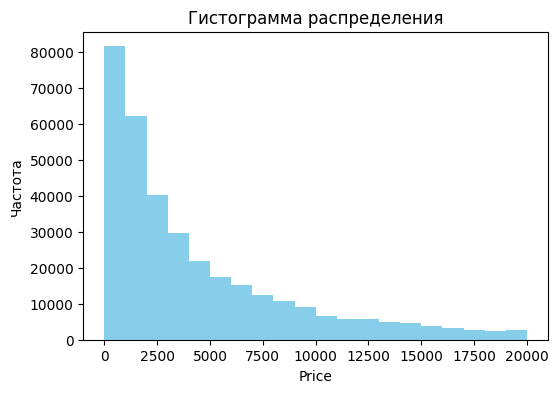

Описание данных в колонке RegistrationYear


count    342535.000000
mean       2004.224704
std          91.122800
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

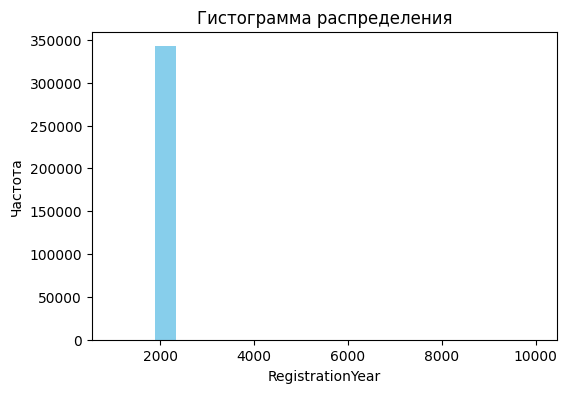

Описание данных в колонке Power


count    342535.000000
mean        109.971717
std         191.863810
min           0.000000
25%          68.000000
50%         104.000000
75%         141.000000
max       20000.000000
Name: Power, dtype: float64

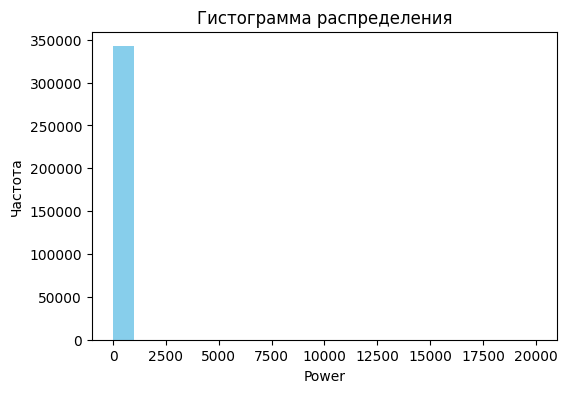

Описание данных в колонке Kilometer


count    342535.000000
mean     128226.239654
std       37926.776381
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64

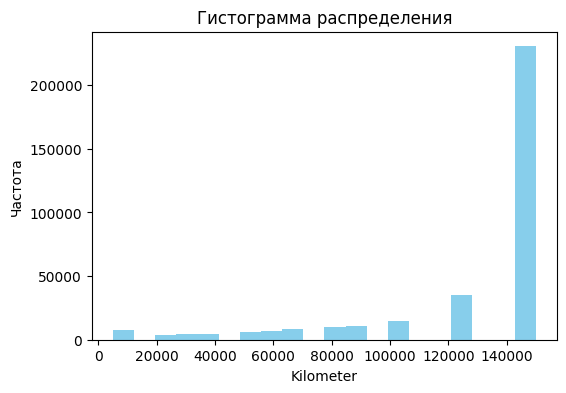

Описание данных в колонке RegistrationMonth


count    342535.000000
mean          5.699803
std           3.729032
min           0.000000
25%           3.000000
50%           6.000000
75%           9.000000
max          12.000000
Name: RegistrationMonth, dtype: float64

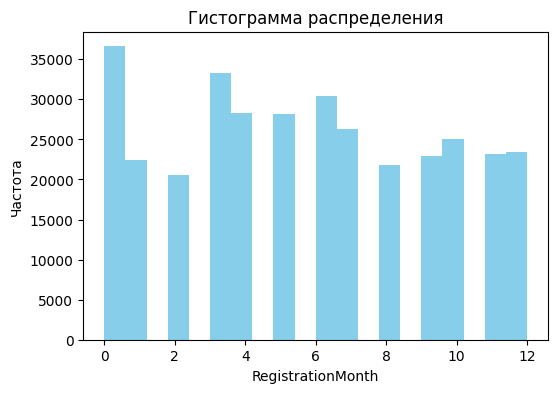

In [22]:
# Оценим количественные признаки 
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Примените функцию show_box_hist к каждому количественному столбцу в цикле
for col in numeric_cols:
    show_box_hist(df[col], show_boxplot=False, bins=20)

Выбросы в колонках:
- Power = макисимум 20000 вряд ли отражает реальность
- RegistrationYear  - все что бльше даты загрузки объявления не отражает реальность

### Анализ категориальных значений

In [23]:
def cat_col_pie(col):
    """
    Функция, которая строит круговую и столбиковую диаграммы для категориального параметра.

    Параметры:
    - col (pandas.Series): Категориальный параметр для анализа.
    """
    print('Количество значений в колонке {}'.format(col.name))
    display(col.value_counts(normalize=True))

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    fig.suptitle('Оценка долей значений в категориальных параметрах: {}'.format(col.name))

    # Построение круговой диаграммы
    col.value_counts().plot(kind='pie', ax=axes[0], autopct="%.1f%%")
    axes[0].set_title('Доли по категориям')
    axes[0].set_ylabel('')

    # Построение столбиковой диаграммы
    col.value_counts().sort_values(ascending=True).plot(kind='barh', ax=axes[1], color='skyblue')
    axes[1].set_title('Количество в группах')
    axes[1].set_xlabel('Количество')

    plt.tight_layout() # Автоматический подбор отступов между графиками
    plt.show()



Количество значений в колонке VehicleType


VehicleType
sedan          0.287720
small          0.252567
wagon          0.205108
bus            0.091193
convertible    0.063842
coupe          0.051277
suv            0.037701
other          0.010592
Name: proportion, dtype: float64

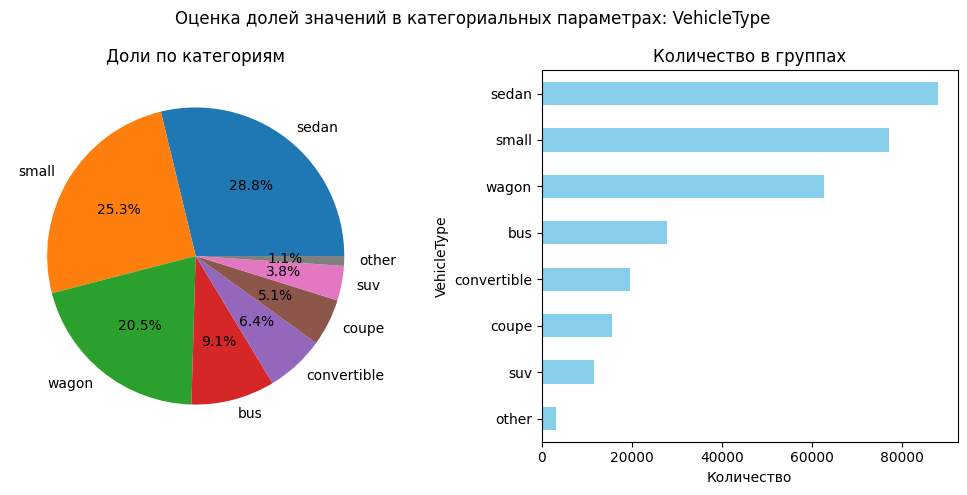

Количество значений в колонке Gearbox


Gearbox
manual    0.802313
auto      0.197687
Name: proportion, dtype: float64

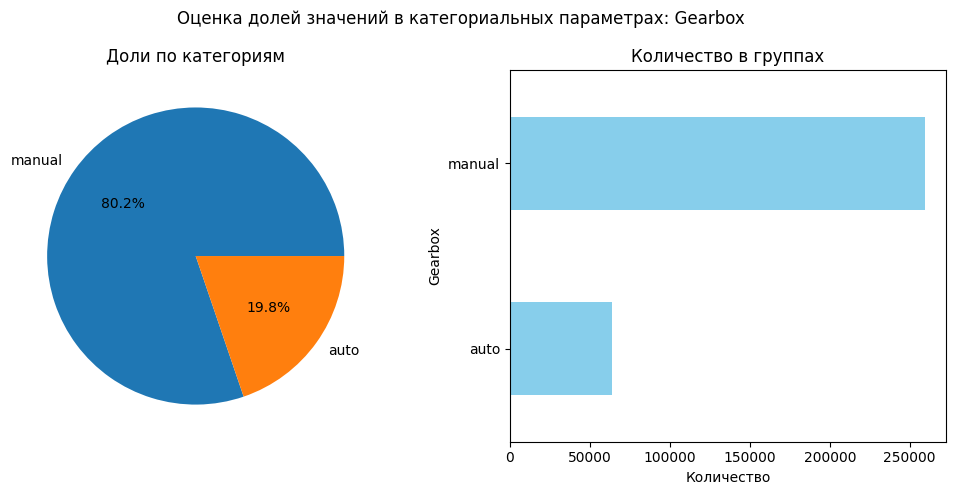

Количество значений в колонке Model


Model
golf                  0.086980
other                 0.073597
3er                   0.058752
polo                  0.039138
corsa                 0.037541
                        ...   
i3                    0.000025
serie_3               0.000012
rangerover            0.000012
serie_1               0.000006
range_rover_evoque    0.000003
Name: proportion, Length: 250, dtype: float64

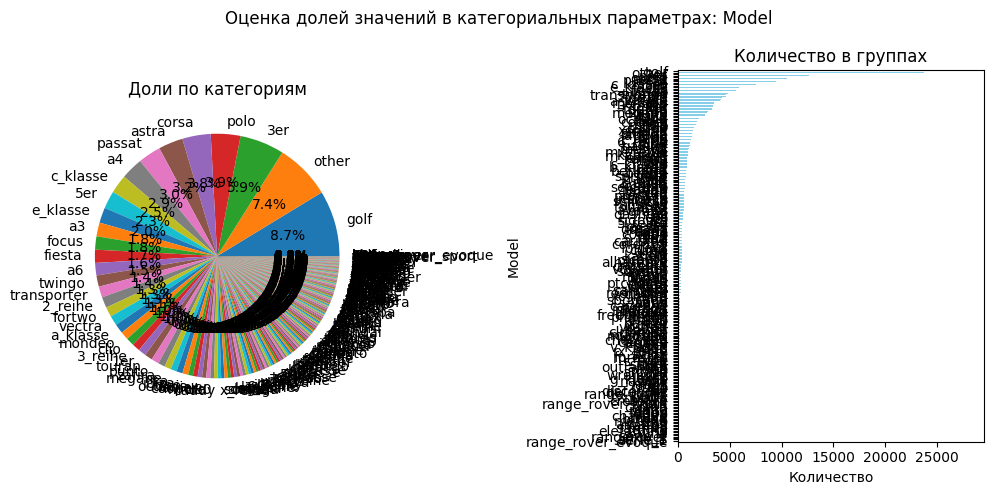

Количество значений в колонке FuelType


FuelType
petrol      0.675578
gasoline    0.304483
lpg         0.016481
cng         0.001789
hybrid      0.000735
other       0.000648
electric    0.000287
Name: proportion, dtype: float64

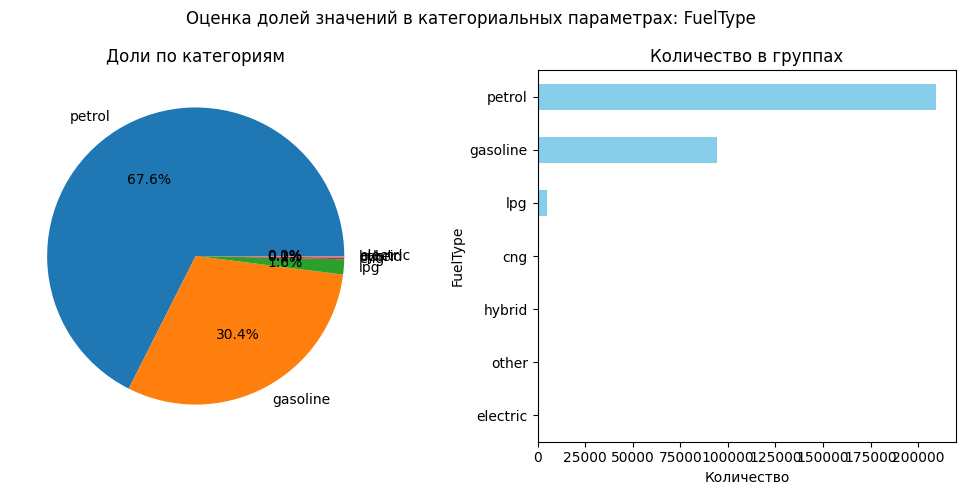

Количество значений в колонке Brand


Brand
volkswagen        0.216571
opel              0.112812
bmw               0.103642
mercedes_benz     0.090651
audi              0.082549
ford              0.071269
renault           0.050999
peugeot           0.031030
fiat              0.027329
seat              0.019543
mazda             0.015931
skoda             0.015490
smart             0.014880
citroen           0.014626
nissan            0.014066
toyota            0.013111
hyundai           0.010107
sonstige_autos    0.009546
volvo             0.009018
mini              0.009006
mitsubishi        0.008630
honda             0.008014
kia               0.006954
suzuki            0.006589
alfa_romeo        0.006539
chevrolet         0.004960
chrysler          0.004093
dacia             0.002540
daihatsu          0.002298
subaru            0.002178
porsche           0.002134
jeep              0.001918
trabant           0.001687
daewoo            0.001533
land_rover        0.001530
saab              0.001463
jaguar            0.00

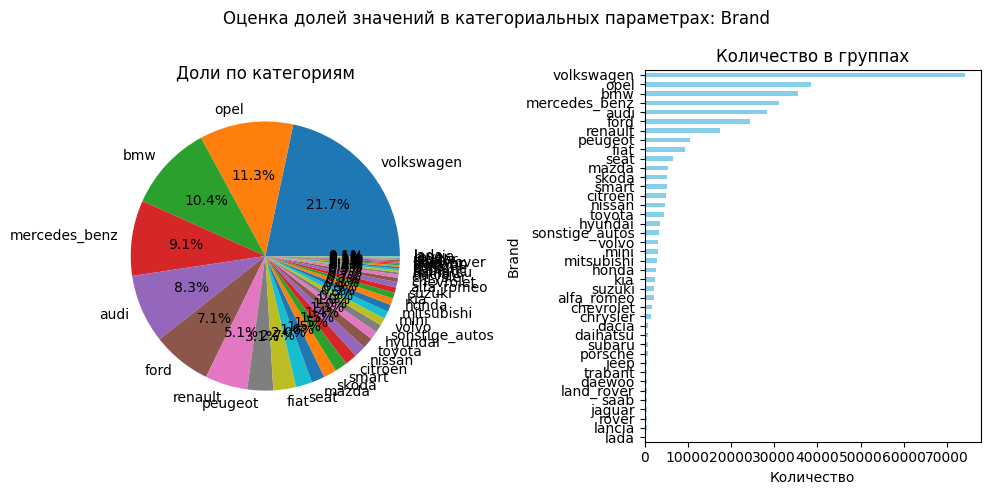

Количество значений в колонке Repaired


Repaired
no     0.870749
yes    0.129251
Name: proportion, dtype: float64

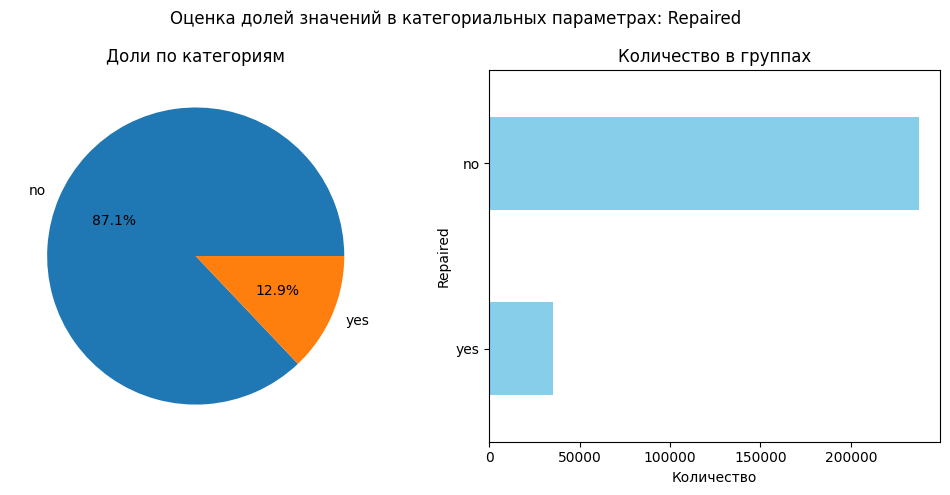

In [25]:
# Оценим качественные признаки 
category_cols = df.select_dtypes(include=['object']).columns

# Примените функцию show_box_hist к каждому количественному столбцу в цикле
for col in category_cols:
    cat_col_pie(df[col])